Import classes

In [17]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from crossbar import crossbar, ticket
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


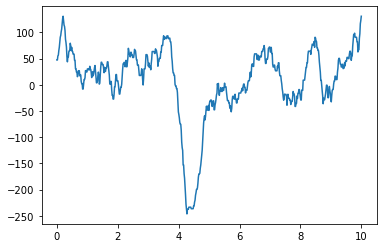

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
--------data successfully filtered (dvariance)--------
X_train: shape of(2562, 28, 31)
X_test: shape of(2649, 28, 31)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


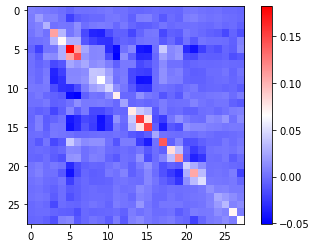

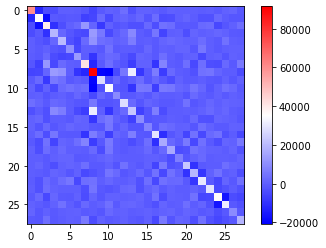

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

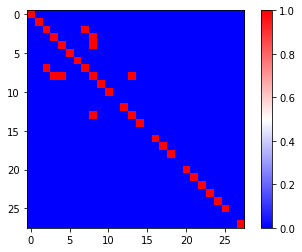

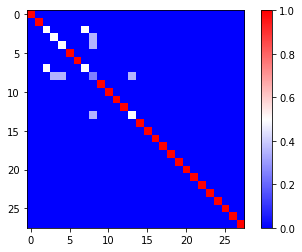

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

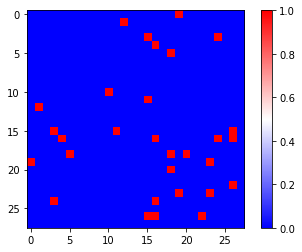

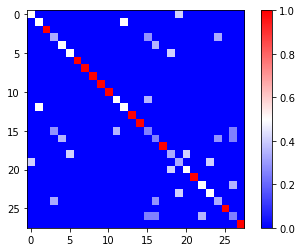

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

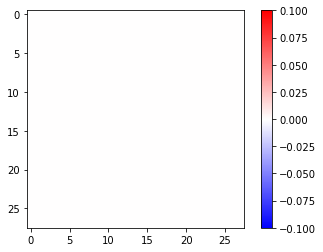

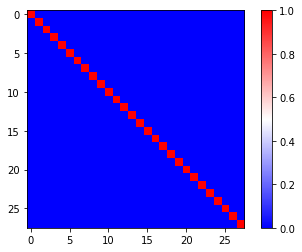

In [8]:
n = 1000.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  A3#dm.A_train

#### Crossbar GCN

In [73]:
device_params_A = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 56,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}
device_params_W = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 64,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3,
    'cb_A': crossbar(device_params_A),
    'cb_Ws': [crossbar(device_params_W), crossbar(device_params_W)]
}
checkpoint = {'parameters': GCNparameters}
#print(GCNparameters['cb_Ws'])

device_params_A = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 56,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600, 
                 "r_cmos_transistor": 20, 
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.05,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}

In [74]:
from GCN import *
from tqdm import tqdm

# takes in numpy arrays
def train_GCN_wCB(A, X_train, X_test, checkpoint, device_name='cpu', load=False):
    # preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    if device_name == 'cuda':
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print("device set to cuda") if device == torch.device('cuda') else print("cuda is not available")
    elif device_name == 'cpu':
        device = torch.device('cpu')
        print("device set to cpu")
    else:
        device = torch.device('cpu')
        print("unknown device")
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)

    # initialize model
    model = Net_wCB(parameters['body'], parameters['n_layers'],A, parameters['cb_A'], parameters['cb_Ws'], F.relu).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'],weight_decay=parameters['weight_decay']) #torch.optim.SGD(model.parameters(), lr=parameters['learning_rate'], momentum=0.5)
    criterion = sim_loss()

    # load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']

    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs + 1):

        permutation = torch.randperm(input_features.shape[0])
        permutation_v = torch.randperm(valid_features.shape[0])

        for i in tqdm(range(0, input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size] if i + batch_size < input_features.shape[0] else permutation[i:]
            indices_v = permutation_v[i:i + batch_size] if i + batch_size < valid_features.shape[0] else permutation_v[i:]
            batch_x = input_features[indices, :, :]
            batch_v = valid_features[indices_v, :, :]

            sim_matrix = model(batch_x).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            model.remap()

            model.eval()
            sim_matrix_valid = model(batch_v).to(device)
            valid_loss = criterion(sim_matrix_valid, A)

            print("Epoch:", epoch + cumepoch, "  Batch:", int((i / batch_size) + 1), "of size", batch_size,
                  "  Train loss:", float(train_loss), "  Valid loss:", float(valid_loss), end="\r")
        print()

    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }

    return model, checkpoint

In [75]:
GCNcb, GCNcbCheckpoint = train_GCN_wCB(create_DAD(Araw), dm.X_train, dm.X_test, checkpoint, device_name='cpu', load=False)

device set to cpu


  0%|          | 0/11 [00:00<?, ?it/s]

remap successfully


  9%|▉         | 1/11 [05:38<56:23, 338.38s/it]

remap successfully1 of size 256   Train loss: 181.57318115234375   Valid loss: 180.05343627929688


 18%|█▊        | 2/11 [11:16<50:44, 338.27s/it]

remap successfully2 of size 256   Train loss: 179.9580841064453   Valid loss: 178.3218994140625


 27%|██▋       | 3/11 [16:54<45:06, 338.26s/it]

remap successfully3 of size 256   Train loss: 178.33966064453125   Valid loss: 176.76669311523438


 36%|███▋      | 4/11 [22:33<39:29, 338.43s/it]

remap successfully4 of size 256   Train loss: 176.77346801757812   Valid loss: 175.30047607421875


 45%|████▌     | 5/11 [28:12<33:51, 338.54s/it]

remap successfully5 of size 256   Train loss: 175.2637939453125   Valid loss: 173.7606658935547


 55%|█████▍    | 6/11 [33:50<28:12, 338.49s/it]

remap successfully6 of size 256   Train loss: 173.6855010986328   Valid loss: 172.34130859375


 64%|██████▎   | 7/11 [39:29<22:33, 338.49s/it]

remap successfully7 of size 256   Train loss: 172.17723083496094   Valid loss: 170.8773193359375


 73%|███████▎  | 8/11 [45:07<16:55, 338.34s/it]

remap successfully8 of size 256   Train loss: 170.8491973876953   Valid loss: 169.33047485351562


 82%|████████▏ | 9/11 [50:46<11:17, 338.62s/it]

remap successfully9 of size 256   Train loss: 169.1919708251953   Valid loss: 167.93161010742188


 91%|█████████ | 10/11 [56:24<05:38, 338.52s/it]

remap successfully10 of size 256   Train loss: 167.902099609375   Valid loss: 166.53128051757812


100%|██████████| 11/11 [57:25<00:00, 313.18s/it]

Epoch: 1   Batch: 11 of size 256   Train loss: 167.04124450683594   Valid loss: 165.31874084472656


In [77]:
GCNcb.eval()
test_pred = GCNcb(torch.from_numpy(dm.X_train[:128, :,:]).float().to('cpu')).cpu().detach().numpy()

sample 0   label, 0.0


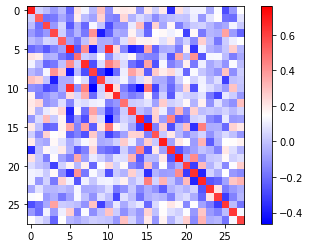

sample 1   label, 0.0


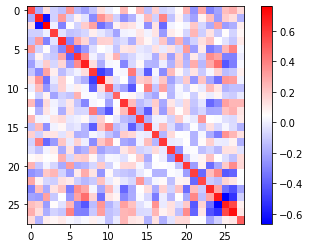

sample 2   label, 0.0


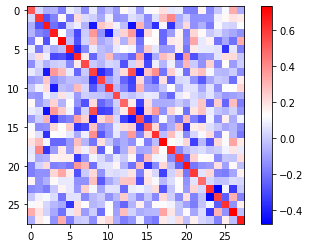

sample 3   label, 0.0


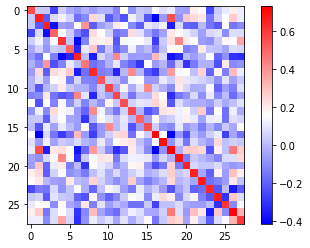

sample 4   label, 0.0


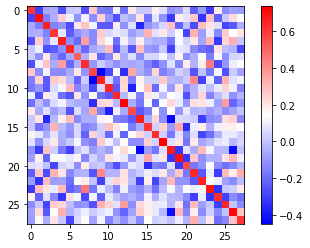

sample 5   label, 0.0


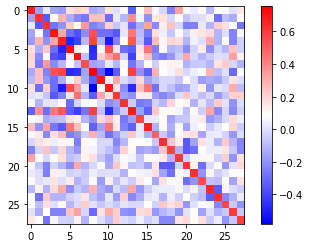

sample 6   label, 0.0


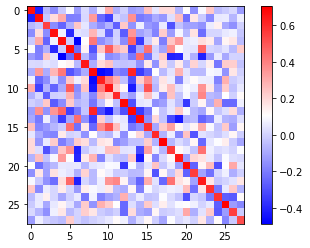

sample 7   label, 0.0


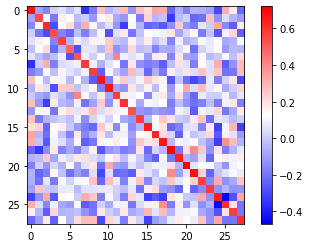

sample 8   label, 0.0


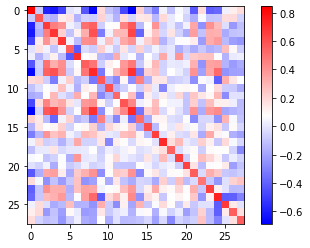

sample 9   label, 0.0


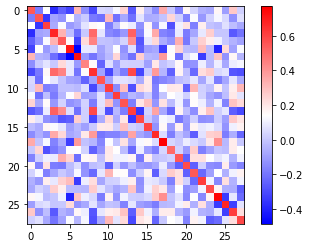

In [78]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

MLP

In [80]:
#Get simularity matrix from GCN
sim_all = {}
GCNcb.eval()
sim_all["GCN_train"] = GCNcb(torch.from_numpy(dm.X_train).float().to('cpu')).cpu().detach().numpy()
sim_all["GCN_test"] = GCNcb(torch.from_numpy(dm.X_test).float().to('cpu')).cpu().detach().numpy()

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


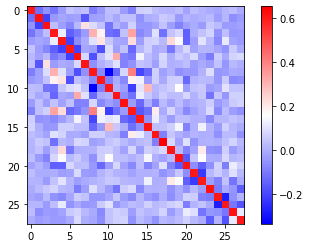

Average Non-Ictal


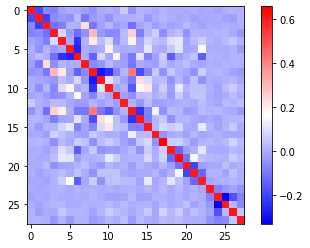

In [81]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

In [ ]:
#Without crossbar

In [84]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=406, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 406]               0
            Linear-2                    [-1, 8]           3,256
              ReLU-3                    [-1, 8]               0
           Dropout-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
           Sigmoid-6                    [-1, 1]               0
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Esti

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


 3   Train loss: 0.4682   Train accuracy: 0.656   Val loss: 0.4466   Val accuracy: 0.691    weighted Val loss: 0.5435
0.691 ----------saved-----------
Epoch: 4   Train loss: 0.3996   Train accuracy: nan   Val loss: 0.4113   Val accuracy: 0.717    weighted Val loss: 0.5428
0.717 ----------saved-----------
Epoch: 5   Train loss: 0.3693   Train accuracy: nan   Val loss: 0.3799   Val accuracy: 0.736    weighted Val loss: 0.542
0.736 ----------saved-----------
Epoch: 6   Train loss: 0.3595   Train accuracy: 0.769   Val loss: 0.3569   Val accuracy: 0.762    weighted Val loss: 0.5411
0.762 ----------saved-----------
Epoch: 7   Train loss: 0.3151   Train accuracy: nan   Val loss: 0.3415   Val accuracy: 0.779    weighted Val loss: 0.5401
0.779 ----------saved-----------
Epoch: 8   Train loss: 0.3245   Train accuracy: 0.818   Val loss: 0.3272   Val accuracy: 0.79    weighted Val loss: 0.539
0.79 ----------saved-----------
Epoch: 9   Train loss: 0.2799   Train accuracy: nan   Val loss: 0.3178   V

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Epoch: 40   Train loss: 0.1455   Train accuracy: nan   Val loss: 0.2201   Val accuracy: 0.865    weighted Val loss: 0.4966
0.865 ----------saved-----------
Epoch: 41   Train loss: 0.1478   Train accuracy: nan   Val loss: 0.22   Val accuracy: 0.867    weighted Val loss: 0.4953
0.867 ----------saved-----------
Epoch: 42   Train loss: 0.1466   Train accuracy: nan   Val loss: 0.2201   Val accuracy: 0.867    weighted Val loss: 0.4939
0.867 ----------saved-----------
Epoch: 43   Train loss: 0.1411   Train accuracy: nan   Val loss: 0.2188   Val accuracy: 0.868    weighted Val loss: 0.4925
0.868 ----------saved-----------
Epoch: 44   Train loss: 0.1411   Train accuracy: nan   Val loss: 0.2186   Val accuracy: 0.87    weighted Val loss: 0.4911
0.87 ----------saved-----------
Epoch: 45   Train loss: 0.1414   Train accuracy: nan   Val loss: 0.2166   Val accuracy: 0.871    weighted Val loss: 0.4898
0.871 ----------saved-----------
Epoch: 46   Train loss: 0.1384   Train accuracy: nan   Val loss: 0.2

device set to cuda
threshold: 0.05  validation loss: 0.1864 F1 accuracy 0.46 Precision accuracy 0.315 Recall accuracy 0.858 AUC accuracy: 0.904
device set to cuda
threshold: 0.1  validation loss: 0.1864 F1 accuracy 0.557 Precision accuracy 0.436 Recall accuracy 0.773 AUC accuracy: 0.904
device set to cuda
threshold: 0.15  validation loss: 0.1864 F1 accuracy 0.612 Precision accuracy 0.536 Recall accuracy 0.715 AUC accuracy: 0.904
device set to cuda
threshold: 0.2  validation loss: 0.1864 F1 accuracy 0.643 Precision accuracy 0.604 Recall accuracy 0.688 AUC accuracy: 0.904
device set to cuda
threshold: 0.25  validation loss: 0.1864 F1 accuracy 0.66 Precision accuracy 0.666 Recall accuracy 0.654 AUC accuracy: 0.904
device set to cuda
threshold: 0.3  validation loss: 0.1864 F1 accuracy 0.672 Precision accuracy 0.723 Recall accuracy 0.627 AUC accuracy: 0.904
device set to cuda
threshold: 0.35  validation loss: 0.1864 F1 accuracy 0.677 Precision accuracy 0.782 Recall accuracy 0.597 AUC accura

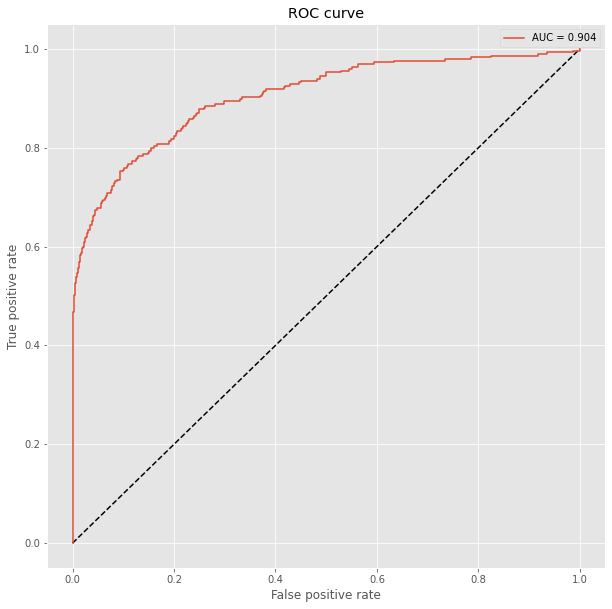

In [85]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)
MLP.eval_plot_MLP(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda')

In [ ]:
#With crossbar (ex-situ)

In [92]:
device_params_MLPW1 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 512,
                 "n": 16,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}

device_params_MLPW2 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 16,
                 "n": 16,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}


In [95]:
MLPGCNCBmodel = MLP.MLPtoMLPwCB(MLPmodelGCN.to('cpu'), [device_params_MLPW1,device_params_MLPW2])

0 layers.1.weight torch.Size([8, 406])
1 layers.1.bias torch.Size([8])
2 layers.4.weight torch.Size([1, 8])
3 layers.4.bias torch.Size([1])
--- weight initialized successfually ---
--- weight initialized successfually ---


  0%|          | 0/2649 [00:00<?, ?it/s]

device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  2%|▏         | 43/2649 [00:00<00:06, 426.88it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:19, 18.92it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.05  validation loss: 0.1882 F1 accuracy 0.396 Precision accuracy 0.254 Recall accuracy 0.902 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 495.98it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:25, 18.23it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.1  validation loss: 0.1882 F1 accuracy 0.533 Precision accuracy 0.401 Recall accuracy 0.797 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 100/2649 [00:00<00:05, 494.69it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:25, 18.23it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.15  validation loss: 0.1882 F1 accuracy 0.621 Precision accuracy 0.542 Recall accuracy 0.729 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 497.74it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:30, 17.59it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.2  validation loss: 0.1882 F1 accuracy 0.658 Precision accuracy 0.642 Recall accuracy 0.675 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  2%|▏         | 51/2649 [00:00<00:05, 501.13it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:26, 18.07it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.25  validation loss: 0.1882 F1 accuracy 0.697 Precision accuracy 0.76 Recall accuracy 0.644 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▎         | 99/2649 [00:00<00:05, 489.27it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:30, 17.59it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.3  validation loss: 0.1882 F1 accuracy 0.694 Precision accuracy 0.823 Recall accuracy 0.6 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 499.72it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:37, 16.85it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.35  validation loss: 0.1882 F1 accuracy 0.686 Precision accuracy 0.878 Recall accuracy 0.563 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 100/2649 [00:00<00:05, 496.31it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:31, 17.44it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.4  validation loss: 0.1882 F1 accuracy 0.68 Precision accuracy 0.94 Recall accuracy 0.532 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 497.80it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:27, 17.90it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.45  validation loss: 0.1882 F1 accuracy 0.649 Precision accuracy 0.942 Recall accuracy 0.495 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 102/2649 [00:00<00:05, 502.62it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:29, 17.75it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.5  validation loss: 0.1882 F1 accuracy 0.628 Precision accuracy 0.972 Recall accuracy 0.464 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▎         | 97/2649 [00:00<00:05, 488.69it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:43, 16.17it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.55  validation loss: 0.1882 F1 accuracy 0.599 Precision accuracy 1.0 Recall accuracy 0.427 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▎         | 97/2649 [00:00<00:05, 475.14it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:29, 17.75it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.6  validation loss: 0.1882 F1 accuracy 0.582 Precision accuracy 1.0 Recall accuracy 0.41 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 103/2649 [00:00<00:05, 507.70it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:22, 18.57it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.65  validation loss: 0.1882 F1 accuracy 0.547 Precision accuracy 1.0 Recall accuracy 0.376 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 499.21it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:26, 18.07it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.7  validation loss: 0.1882 F1 accuracy 0.51 Precision accuracy 1.0 Recall accuracy 0.342 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  2%|▏         | 45/2649 [00:00<00:05, 446.73it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:29, 17.75it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.75  validation loss: 0.1882 F1 accuracy 0.479 Precision accuracy 1.0 Recall accuracy 0.315 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▎         | 96/2649 [00:00<00:05, 467.79it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:38, 16.71it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.8  validation loss: 0.1882 F1 accuracy 0.435 Precision accuracy 1.0 Recall accuracy 0.278 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 100/2649 [00:00<00:05, 496.37it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:21, 18.74it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.85  validation loss: 0.1882 F1 accuracy 0.392 Precision accuracy 1.0 Recall accuracy 0.244 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 499.82it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:38, 16.71it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.9  validation loss: 0.1882 F1 accuracy 0.329 Precision accuracy 1.0 Recall accuracy 0.197 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▍         | 101/2649 [00:00<00:05, 497.79it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


  0%|          | 2/2649 [00:00<02:38, 16.71it/s]

torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])
threshold: 0.95  validation loss: 0.1882 F1 accuracy 0.212 Precision accuracy 1.0 Recall accuracy 0.119 AUC accuracy: 0.906
device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2649, 28, 28])
debug MLPwCB: x size is torch.Size([2649, 406])
torch.Size([2649, 406])


  4%|▎         | 98/2649 [00:00<00:05, 488.85it/s]

torch.Size([2649, 8])
torch.Size([2649, 8])
torch.Size([2649, 8])


100%|██████████| 2649/2649 [00:05<00:00, 491.87it/s]


torch.Size([2649, 1])
torch.Size([2649, 1])
torch.Size([2649, 1])


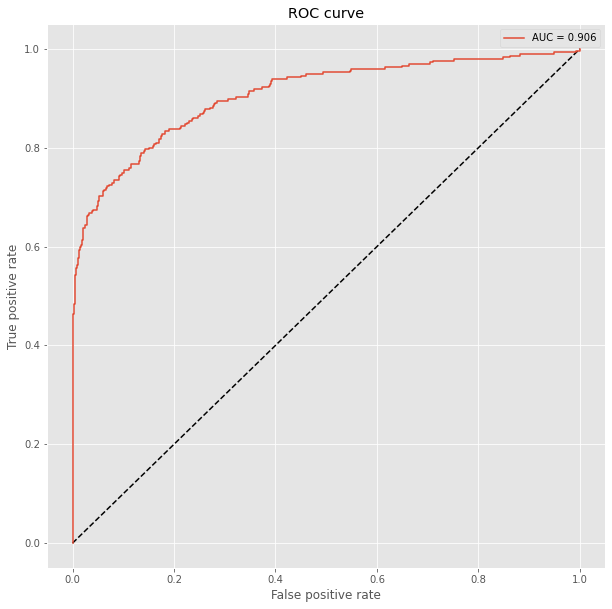

In [96]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPGCNCBmodel, sim_all["GCN_test"], dm, device_name = 'cpu', threshold = t)
MLP.eval_plot_MLP(MLPGCNCBmodel, sim_all["GCN_test"], dm, device_name = 'cpu')

#### Crossbar GDE

In [120]:
device_params_A = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 56,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}
device_params_W = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 64,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3,
    'cb_A': crossbar(device_params_A),
    'cb_Ws': [crossbar(device_params_W)]
}
GEDcheckpoint = {'parameters': GDEparameters}

In [121]:
from GDE import *
from tqdm import tqdm

def train_GDE_wCB(A, X_train, X_test, checkpoint, device_name = 'cpu',load=False):
    # preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    if device_name == 'cuda':
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print("device set to cuda") if device == torch.device('cuda') else print("cuda is not available")
    elif device_name == 'cpu':
        device = torch.device('cpu')
        print("device set to cpu")
    else:
        device = torch.device('cpu')
        print("unknown device")
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)

    # (solver, body_channels, hidden_layers, A, solver_params)
    # initialize model
    model = ODENet_wCB(parameters['solver'], parameters['body'], parameters['hidden_layers'], A,
                   parameters['solver_params'], parameters['cb_A'], parameters['cb_Ws']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'],
                                 weight_decay=parameters['weight_decay'])
    criterion = sim_loss()

    # load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']

    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs + 1):

        permutation = torch.randperm(input_features.shape[0])
        permutation_v = torch.randperm(valid_features.shape[0])

        for i in tqdm(range(0, input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size] if i + batch_size < input_features.shape[0] else permutation[i:]
            indices_v = permutation_v[i:i + batch_size] if i + batch_size < valid_features.shape[0] else permutation_v[i:]
            batch_x = input_features[indices, :, :]
            batch_v = valid_features[indices_v, :, :]

            sim_matrix = model(batch_x).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            model.remap()

            model.eval()
            sim_matrix_valid = model(batch_v).to(device)
            valid_loss = criterion(sim_matrix_valid, A)

            print("Epoch:", epoch + cumepoch, "  Batch:", int((i / batch_size) + 1), "of size", batch_size,
                  "  Train loss:", float(train_loss), "  Valid loss:", float(valid_loss), end="\r")
        print()

    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }

    return model, checkpoint

In [122]:
GDEcb, GDEcbCheckpoint = train_GDE_wCB(create_DAD(Araw), dm.X_train, dm.X_test, GEDcheckpoint, device_name='cpu', load=False)

device set to cpu


  0%|          | 0/21 [00:00<?, ?it/s]

remap successfully


  5%|▍         | 1/21 [15:18<5:06:04, 918.25s/it]

remap successfully1 of size 128   Train loss: 180.92776489257812   Valid loss: 179.40713500976562


 10%|▉         | 2/21 [31:55<4:58:18, 942.03s/it]

remap successfully2 of size 128   Train loss: 179.287353515625   Valid loss: 177.85211181640625


 14%|█▍        | 3/21 [50:07<4:56:02, 986.83s/it]

remap successfully3 of size 128   Train loss: 177.73851013183594   Valid loss: 176.2049560546875


 19%|█▉        | 4/21 [1:05:30<4:34:13, 967.85s/it]

remap successfully4 of size 128   Train loss: 176.1518096923828   Valid loss: 174.74716186523438


 24%|██▍       | 5/21 [1:20:58<4:14:53, 955.84s/it]

remap successfully5 of size 128   Train loss: 174.7337188720703   Valid loss: 173.460205078125


 29%|██▊       | 6/21 [1:36:23<3:56:36, 946.45s/it]

remap successfully6 of size 128   Train loss: 173.16336059570312   Valid loss: 171.93389892578125


 33%|███▎      | 7/21 [1:51:51<3:39:35, 941.09s/it]

remap successfully7 of size 128   Train loss: 171.830810546875   Valid loss: 170.4968719482422


 38%|███▊      | 8/21 [2:07:19<3:23:01, 937.06s/it]

remap successfully8 of size 128   Train loss: 170.36790466308594   Valid loss: 169.30300903320312


 43%|████▎     | 9/21 [2:22:39<3:06:25, 932.09s/it]

remap successfully9 of size 128   Train loss: 168.940673828125   Valid loss: 167.68002319335938


 48%|████▊     | 10/21 [2:37:57<2:50:06, 927.84s/it]

remap successfully10 of size 128   Train loss: 167.5545196533203   Valid loss: 166.17422485351562


 52%|█████▏    | 11/21 [2:53:15<2:34:08, 924.86s/it]

remap successfully11 of size 128   Train loss: 166.4916534423828   Valid loss: 165.0355682373047


 57%|█████▋    | 12/21 [3:08:39<2:18:41, 924.61s/it]

remap successfully12 of size 128   Train loss: 165.02276611328125   Valid loss: 163.72030639648438


 62%|██████▏   | 13/21 [3:24:00<2:03:08, 923.56s/it]

remap successfully13 of size 128   Train loss: 163.7357177734375   Valid loss: 162.53240966796875


 67%|██████▋   | 14/21 [3:39:16<1:47:27, 921.10s/it]

remap successfully14 of size 128   Train loss: 162.53659057617188   Valid loss: 161.40664672851562


 71%|███████▏  | 15/21 [3:54:37<1:32:07, 921.27s/it]

remap successfully15 of size 128   Train loss: 161.27993774414062   Valid loss: 160.4254150390625


 76%|███████▌  | 16/21 [4:10:08<1:17:00, 924.06s/it]

remap successfully16 of size 128   Train loss: 160.37074279785156   Valid loss: 158.89114379882812


 81%|████████  | 17/21 [4:25:36<1:01:41, 925.27s/it]

remap successfully17 of size 128   Train loss: 159.01004028320312   Valid loss: 157.9437255859375


 86%|████████▌ | 18/21 [4:41:04<46:18, 926.09s/it]  

remap successfully18 of size 128   Train loss: 157.98635864257812   Valid loss: 156.73114013671875


 90%|█████████ | 19/21 [4:58:31<32:04, 962.29s/it]

remap successfully19 of size 128   Train loss: 157.14004516601562   Valid loss: 156.31314086914062


 95%|█████████▌| 20/21 [5:16:05<16:29, 989.77s/it]

remap successfully20 of size 128   Train loss: 156.0216064453125   Valid loss: 155.1855926513672


100%|██████████| 21/21 [5:19:06<00:00, 911.72s/it]

Epoch: 1   Batch: 21 of size 128   Train loss: 158.26864624023438   Valid loss: 153.57696533203125


In [125]:
GDEcb.eval()
test_pred = GDEcb(torch.from_numpy(dm.X_train[:128, :,:]).float().to('cpu')).cpu().detach().numpy()

In [143]:
GDEutil.save_ckp(GDEcbCheckpoint, "models/MGDE1_273.pt")

model saved


sample 0   label, 0.0


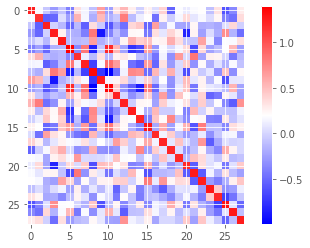

sample 1   label, 0.0


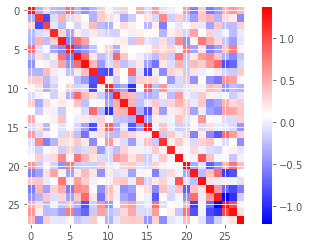

sample 2   label, 0.0


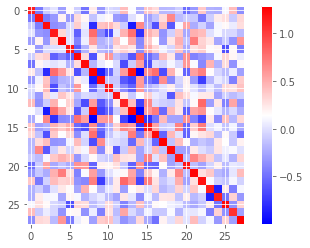

sample 3   label, 0.0


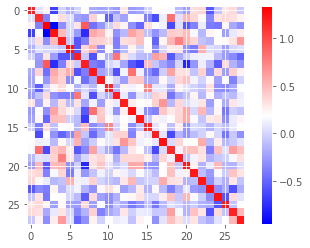

sample 4   label, 0.0


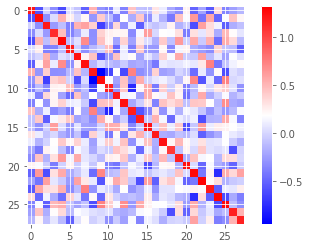

sample 5   label, 0.0


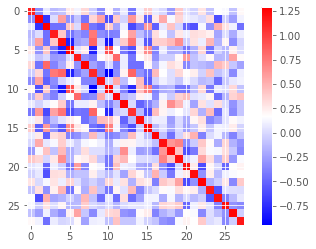

sample 6   label, 0.0


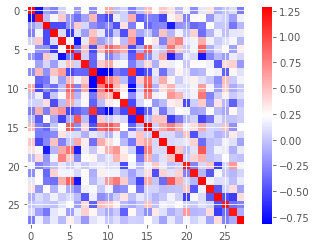

sample 7   label, 0.0


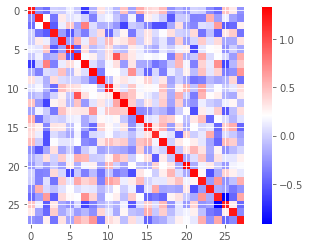

sample 8   label, 0.0


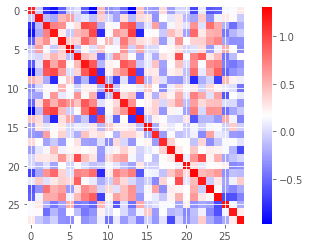

sample 9   label, 0.0


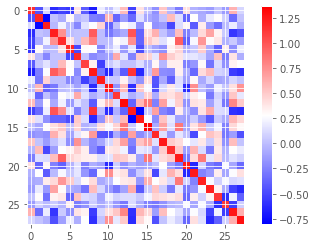

In [126]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

MLP

In [127]:
#Get simularity matrix from GCN
sim_all = {}
GDEcb.eval()
sim_all["GDE_train"] = GDEcb(torch.from_numpy(dm.X_train).float().to('cpu')).cpu().detach().numpy()
sim_all["GDE_test"] = GDEcb(torch.from_numpy(dm.X_test).float().to('cpu')).cpu().detach().numpy()

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


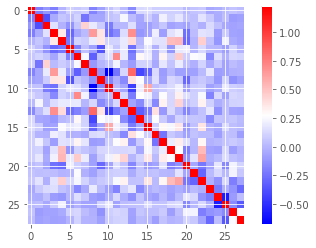

Average Non-Ictal


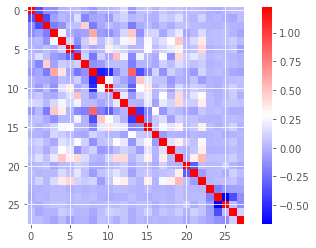

In [129]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GDE_train"], sim_all["GDE_test"])

In [ ]:
#Without crossbar

In [131]:
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGDE, _,_, MLPcheckpointGDE = MLP.train_MLP(dm, sim_all["GDE_train"], sim_all["GDE_test"], MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=406, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 406]               0
            Linear-2                    [-1, 8]           3,256
              ReLU-3                    [-1, 8]               0
           Dropout-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
           Sigmoid-6                    [-1, 1]               0
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Esti

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


  Train accuracy: nan   Val loss: 0.3409   Val accuracy: 0.745    weighted Val loss: 0.5353
0.745 ----------saved-----------
Epoch: 4   Train loss: 0.2829   Train accuracy: nan   Val loss: 0.3168   Val accuracy: 0.772    weighted Val loss: 0.5342
0.772 ----------saved-----------
Epoch: 5   Train loss: 0.2597   Train accuracy: nan   Val loss: 0.2994   Val accuracy: 0.798    weighted Val loss: 0.5331
0.798 ----------saved-----------
Epoch: 6   Train loss: 0.243   Train accuracy: nan   Val loss: 0.285   Val accuracy: 0.814    weighted Val loss: 0.5318
0.814 ----------saved-----------
Epoch: 7   Train loss: 0.2185   Train accuracy: nan   Val loss: 0.2733   Val accuracy: 0.825    weighted Val loss: 0.5305
0.825 ----------saved-----------
Epoch: 8   Train loss: 0.2042   Train accuracy: nan   Val loss: 0.2634   Val accuracy: 0.834    weighted Val loss: 0.5292
0.834 ----------saved-----------
Epoch: 9   Train loss: 0.1998   Train accuracy: nan   Val loss: 0.2541   Val accuracy: 0.844    weight

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


0.914 ----------saved-----------
Epoch: 65   Train loss: 0.093   Train accuracy: nan   Val loss: 0.168   Val accuracy: 0.916    weighted Val loss: 0.4437
0.916 ----------saved-----------
Epoch: 66   Train loss: 0.0946   Train accuracy: nan   Val loss: 0.168   Val accuracy: 0.916    weighted Val loss: 0.4424
0.916 ----------saved-----------
Epoch: 67   Train loss: 0.0892   Train accuracy: nan   Val loss: 0.1673   Val accuracy: 0.917    weighted Val loss: 0.441
0.917 ----------saved-----------
Epoch: 68   Train loss: 0.0946   Train accuracy: nan   Val loss: 0.1667   Val accuracy: 0.917    weighted Val loss: 0.4396
0.917 ----------saved-----------
Epoch: 69   Train loss: 0.086   Train accuracy: nan   Val loss: 0.1668   Val accuracy: 0.917    weighted Val loss: 0.4383
Epoch: 70   Train loss: 0.087   Train accuracy: nan   Val loss: 0.1666   Val accuracy: 0.917    weighted Val loss: 0.4369
0.917 ----------saved-----------
Epoch: 71   Train loss: 0.0842   Train accuracy: nan   Val loss: 0.166

device set to cuda
threshold: 0.05  validation loss: 0.1679 F1 accuracy 0.43 Precision accuracy 0.282 Recall accuracy 0.905 AUC accuracy: 0.918
device set to cuda
threshold: 0.1  validation loss: 0.1679 F1 accuracy 0.536 Precision accuracy 0.393 Recall accuracy 0.844 AUC accuracy: 0.918
device set to cuda
threshold: 0.15  validation loss: 0.1679 F1 accuracy 0.602 Precision accuracy 0.477 Recall accuracy 0.814 AUC accuracy: 0.918
device set to cuda
threshold: 0.2  validation loss: 0.1679 F1 accuracy 0.655 Precision accuracy 0.56 Recall accuracy 0.79 AUC accuracy: 0.918
device set to cuda
threshold: 0.25  validation loss: 0.1679 F1 accuracy 0.691 Precision accuracy 0.632 Recall accuracy 0.763 AUC accuracy: 0.918
device set to cuda
threshold: 0.3  validation loss: 0.1679 F1 accuracy 0.722 Precision accuracy 0.706 Recall accuracy 0.739 AUC accuracy: 0.918
device set to cuda
threshold: 0.35  validation loss: 0.1679 F1 accuracy 0.729 Precision accuracy 0.743 Recall accuracy 0.715 AUC accurac

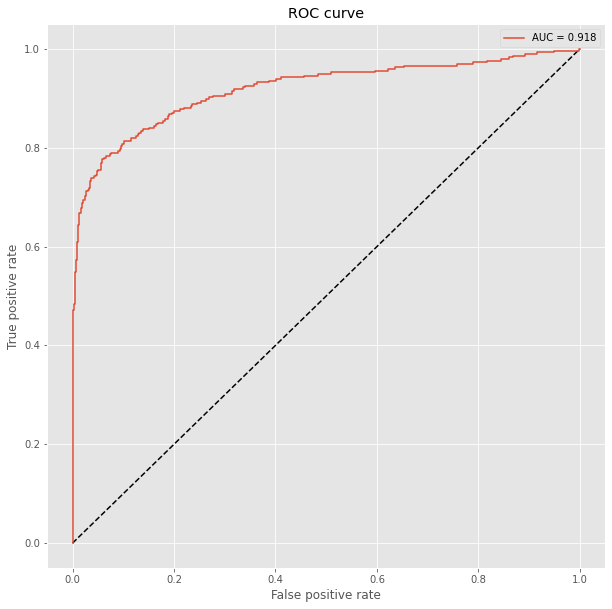

In [134]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda', threshold = t)
MLP.eval_plot_MLP(MLPmodelGDE, sim_all["GDE_test"], dm, device_name = 'cuda')

In [135]:
#With crossbar (ex-situ)

In [139]:
device_params_MLPW1 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 512,
                 "n": 16,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.05,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}

device_params_MLPW2 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 16,
                 "n": 16,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.05,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}


In [140]:
MLPGDECBmodel = MLP.MLPtoMLPwCB(MLPmodelGDE.to('cpu'), [device_params_MLPW1,device_params_MLPW2])

0 layers.1.weight torch.Size([8, 406])
1 layers.1.bias torch.Size([8])
2 layers.4.weight torch.Size([1, 8])
3 layers.4.bias torch.Size([1])
--- weight initialized successfually ---
--- weight initialized successfually ---


  0%|          | 0/2649 [00:00<?, ?it/s]

device set to cpu


100%|██████████| 2649/2649 [00:05<00:00, 492.55it/s]


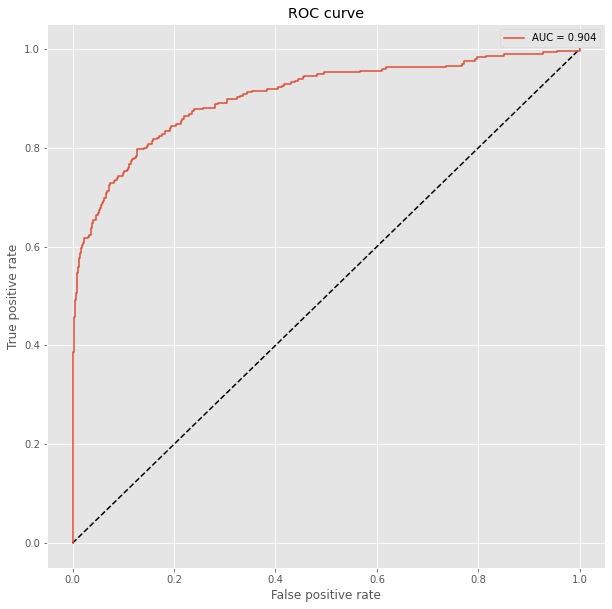

In [141]:
#for i in range(5,100, 5):
#    t = i/100;
#    MLP.eval_mlp(MLPGCNCBmodel, sim_all["GDE_test"], dm, device_name = 'cpu', threshold = t)
MLP.eval_plot_MLP(MLPGDECBmodel, sim_all["GDE_test"], dm, device_name = 'cpu')

# 

## Archives|

Import classes|

In [2]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
import crossbar

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np
#Memtorch
import memtorch
#pandas
import pandas as pd
#Others
import copy

Load Dataset

name: X_test
shape: (640, 23, 2625)
-----------------------
name: X_train
shape: (640, 23, 2473)
-----------------------
name: clip_sizes_test
shape: (2, 135)
-----------------------
name: clip_sizes_train
shape: (2, 133)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2625)
-----------------------
name: sel_win_nums_train
shape: (1, 2473)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2625)
-----------------------
name: y_train
shape: (1, 2473)
-----------------------
print sample EGG signal from one node:


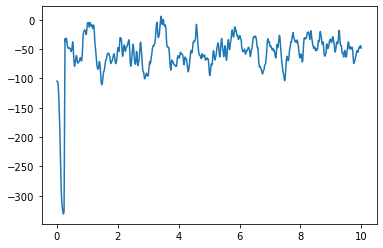

In [3]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_253.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [4]:
#OPTIONAL: Shuffle the dataset
indices = np.load("datasets/indices_253.npy")# load shuffled indices
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, indices = indices, print_summary = True)

X_train: (640, 23, 2549)
X_test: (640, 23, 2549)
y_train: (1, 2549) Positive labes: 261.0
y_test: (1, 2549) Positive labes: 260.0


In [5]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

Load Models

--------data manager successfully initialized--------


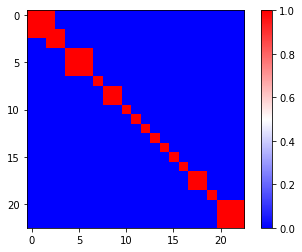

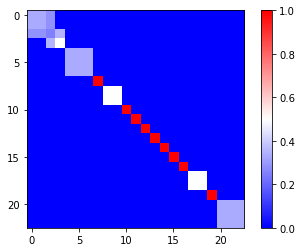

device set to cpu
device set to cpu


In [6]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
n = 3.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train
A = create_DAD(Araw)
GCNmodel, GCNoptimizer = GCNutil.load_model(GCNutil.load_ckp("models/GCN253_1.pt"), device_name ='cpu' )
MLPGCNmodel, MLPGCNoptimizer = MLP.load_model(MLP.load_ckp("models/MLPGCN253_2.pt"), A.shape[1], device_name ='cpu' )

In [7]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

#Get simularity matrix from GCN
GCNmodel.eval()
#print(GCNmodel)
#print(A.shape)
#print(X_train.shape)
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [8]:
#ideal accuracy:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPGCNmodel, sim_all["GCN_test"], dm, threshold = t)

device set to cpu
threshold: 0.05  validation loss: 0.1371 F1 accuracy 0.596 Precision accuracy 0.442 Recall accuracy 0.915 AUC accuracy: 0.959
device set to cpu
threshold: 0.1  validation loss: 0.1371 F1 accuracy 0.653 Precision accuracy 0.517 Recall accuracy 0.888 AUC accuracy: 0.959
device set to cpu
threshold: 0.15  validation loss: 0.1371 F1 accuracy 0.702 Precision accuracy 0.591 Recall accuracy 0.865 AUC accuracy: 0.959
device set to cpu
threshold: 0.2  validation loss: 0.1371 F1 accuracy 0.72 Precision accuracy 0.633 Recall accuracy 0.835 AUC accuracy: 0.959
device set to cpu
threshold: 0.25  validation loss: 0.1371 F1 accuracy 0.732 Precision accuracy 0.665 Recall accuracy 0.815 AUC accuracy: 0.959
device set to cpu
threshold: 0.3  validation loss: 0.1371 F1 accuracy 0.739 Precision accuracy 0.699 Recall accuracy 0.785 AUC accuracy: 0.959
device set to cpu
threshold: 0.35  validation loss: 0.1371 F1 accuracy 0.751 Precision accuracy 0.727 Recall accuracy 0.777 AUC accuracy: 0.

Crossbar (MLP)

In [9]:
cb_size = 560 #MLPGCNmodel.flatten(sim_all["GCN_train"]).shape[1]
print(cb_size)
device_params = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": cb_size,
                 "n": cb_size,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}


560


In [14]:
def MLPtoMLPwCB(srcmodel, cb_params):
    #parameters = checkpoint['parameters']
    device = torch.device('cpu')
    weights = []
    for i, param_tensor in enumerate(srcmodel.state_dict()):
        print(i, param_tensor, srcmodel.state_dict()[param_tensor].shape)
        if i%2 == 0:
            weights.append({"w": srcmodel.state_dict()[param_tensor]})
        else:
            weights[-1]["b"] = srcmodel.state_dict()[param_tensor]
    model = MLP.MLPwCB(srcmodel.matrix_dim, cb_params, srcmodel.n_layers, srcmodel.layer_size_factor,
                   srcmodel.dropout, weights).to(device)
    return model

In [15]:
MLPGCNCBmodel = MLPtoMLPwCB(MLPGCNmodel, [device_params,device_params])

0 layers.0.weight torch.Size([138, 276])
1 layers.0.bias torch.Size([138])
2 layers.2.weight torch.Size([1, 138])
3 layers.2.bias torch.Size([1])
--- weight initialized successfually ---
--- weight initialized successfually ---


In [16]:
from torchsummary import summary
summary(MLPGCNCBmodel, (23,23), device="cpu")

  0%|          | 0/2 [00:00<?, ?it/s]

debug MLPwCB: sim_matrices size is torch.Size([2, 23, 23])
debug MLPwCB: x size is torch.Size([2, 276])
debug BVMM: x is size torch.Size([276, 2])
debug W: torch.Size([138, 276])
debug b: torch.Size([138])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 138])
torch.Size([2, 138])
debug BVMM: x is size torch.Size([138, 2])
debug W: torch.Size([1, 138])
debug b: torch.Size([1])


100%|██████████| 2/2 [00:40<00:00, 20.30s/it]

torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      Linear_block-1                  [-1, 138]               0
              ReLU-2                  [-1, 138]               0
      Linear_block-3                    [-1, 1]               0
           Sigmoid-4                    [-1, 1]               0


AttributeError: 'int' object has no attribute 'numpy'

In [17]:
#crossbar accuracy:
MLP.eval_mlp(MLPGCNCBmodel, sim_all["GCN_test"], dm, threshold = 0.45)

  0%|          | 0/2549 [00:00<?, ?it/s]

device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2549, 23, 23])
debug MLPwCB: x size is torch.Size([2549, 276])
debug BVMM: x is size torch.Size([276, 2549])
debug W: torch.Size([138, 276])
debug b: torch.Size([138])


  0%|          | 0/2549 [00:00<?, ?it/s]

torch.Size([2549, 138])
torch.Size([2549, 138])
debug BVMM: x is size torch.Size([138, 2549])
debug W: torch.Size([1, 138])
debug b: torch.Size([1])


100%|██████████| 2549/2549 [6:40:25<00:00,  9.43s/it]  

torch.Size([2549, 1])
torch.Size([2549, 1])
torch.Size([2549, 1])
threshold: 0.45  validation loss: 0.1719 F1 accuracy 0.696 Precision accuracy 0.601 Recall accuracy 0.827 AUC accuracy: 0.955


0.6957928802588996

In [18]:
import torch
import crossbar
import numpy as np
import random
import os
import time
from tqdm import tqdm

# This testbench tries out a 100 matrices and vectors to multiply.

device_params2 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 128,
                 "n": 128,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
                 "device_resolution": 6
}

cb = crossbar.crossbar(device_params2)

seed = 12
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

max_rows = device_params2["m"] // 2
max_cols = device_params2["n"]

test_num = 10

matrices = [torch.randint(-10, 10, (max_rows, max_cols)) for _ in range(test_num)]
vectors = [torch.randint(-10, 10, (max_cols, 1)) for _ in range(test_num)]


cb_time, t_time, error = 0.0, 0.0, 0.0
for matrix, vector in tqdm(zip(matrices, vectors)):
    cb.clear()
    ticket = cb.register_linear(torch.transpose(matrix,0,1))

    start_time = time.time()
    output = ticket.vmm(vector, v_bits=4)
    cb_time += time.time() - start_time

    start_time = time.time()
    target = matrix.matmul(vector)
    t_time += time.time() - start_time

    error += torch.norm(target - output) / torch.norm(matrix.double())

print("Average crossbar vmm time:", cb_time / test_num, "s")
print("Average torch vmm time:", t_time / test_num, "s")
print("Average relative error:", error / test_num)

10it [00:28,  2.83s/it]

Average crossbar vmm time: 1.6225584983825683 s
Average torch vmm time: 9.97304916381836e-05 s
Average relative error: tensor(1.5568, dtype=torch.float64)
